# FIne-Tunning Text Classifier for more than 1 input

### Example applications:

1. (From instructors) Multiple choice questions: pass as inputs the questions and possible answers, and the model will predict the correct answer.
2. (From instructors) Chatbot with past context: pass past conversation as input
3. (From instructors) QUestion-answering: answer a question along with the passage of text that contains the answer. The model will select the portion of the text where the answer are.

### Task: what are other use cases for Multi-Input Text Classifier?

2. 

### But how can we change the number of inputs?

Remember: Fine-Tunning generally is to keep all the network (including forst layer) the same and only update weights of the last layer.

Answer: we don't need to! We can simply concatenate entries.

It might work with RNN too. Exercise: Think about how that moight work in RNN!

### Recall BERT

BERT is pre-trained in unsupervised NLP tasks.

BRET is pre-trained in two tasks: Next Sentence Prediction (NSP) and textual entailment

In order to train NSP, we build a binary classifier whether the second sentence follows the first one

We use formatted text as following:

"[CLS] This is the sentence one. [SEP] This is the sentence two. [SEP]"

The difference from textual entailment and NSP is the task: now you want to know if the first sentence entails the second sentence.

As in NSP, we train a binary classificator.

Tradução: Queremos saber se a primeira sentença ocasiona a segunda.

Ex.: "Bob buys a car" entails "Bob owns a car".
Ex.? "Bob purchased cheese" doesn't entails "Bob doesn't have cheese"

### Task

#### Compare BERT and DistilBERT

Bert uses the input token_type_id, while DistilBERT doesn't.

Your task is:
1. Check if "token_type_id" is present in BERT, but not in DistilBERT.
2. compare both BERT and DistilBERT in terms of time of execution and 

# Part 1. Warmup!

In [1]:
from datasets import load_dataset, load_metric
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


import torch
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np


Since the dataset ("glue", "rte") didn't have labels for the loaded test split at the moment of this notebook was created, we will split train data in train and test data, instead of use the loaded test data

In [2]:
raw_dataset_temp = load_dataset("glue", "rte", split=["train", "validation"])
raw_dataset_temp

[Dataset({
     features: ['sentence1', 'sentence2', 'label', 'idx'],
     num_rows: 2490
 }),
 Dataset({
     features: ['sentence1', 'sentence2', 'label', 'idx'],
     num_rows: 277
 })]

In [3]:
raw_dataset = raw_dataset_temp[0].train_test_split(test_size=250, seed=42)
raw_dataset['validation'] = raw_dataset_temp[1]
del raw_dataset_temp
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2240
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
})

### Note:

We now have two input sentences is a label!

In [4]:
checkpoint_BERT = "bert-base-cased"
checkpoint_DistilBERT = "distilbert-base-cased"

In [5]:
tokenizer_BERT = AutoTokenizer.from_pretrained(checkpoint_BERT)
tokenizer_DistilBERT = AutoTokenizer.from_pretrained(checkpoint_DistilBERT)

In [6]:
sentence_1 = raw_dataset['train']['sentence1'][0]
sentence_2 = raw_dataset['train']['sentence2'][0]
sentence_1, sentence_2

('A small bronze bust of Spencer Tracy sold for £174,000.',
 'A small bronze bust of Spencer Tracy made £180,447.')

In [7]:
tokenizer_BERT(sentence_1, sentence_2)

{'input_ids': [101, 138, 1353, 4394, 16118, 1104, 6511, 10435, 1962, 1111, 15142, 1559, 1527, 117, 1288, 119, 102, 138, 1353, 4394, 16118, 1104, 6511, 10435, 1189, 15142, 18910, 117, 3140, 1559, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [8]:
tokenizer_DistilBERT(sentence_1, sentence_2)

{'input_ids': [101, 138, 1353, 4394, 16118, 1104, 6511, 10435, 1962, 1111, 15142, 1559, 1527, 117, 1288, 119, 102, 138, 1353, 4394, 16118, 1104, 6511, 10435, 1189, 15142, 18910, 117, 3140, 1559, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

### ✅ Task 1

In [9]:
def get_tokenize_fn(tokenizer):
    def tokenize_fn(batch):
        return tokenizer(batch['sentence1'], batch['sentence2'], truncation=True)
    
    return tokenize_fn

In [10]:
tokenize_fn = get_tokenize_fn(tokenizer_BERT)
tokenized_datasets = raw_dataset.map(tokenize_fn, batched=True)

tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2240
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 277
    })
})

In [11]:
raw_dataset['train'][25]

{'sentence1': 'Hovind, self-styled as "Dr. Dino" (whose Ph.D, from a non-accredited correspondence university, is in Christian education) believes in Biblical literalism claimed that he is not liable for taxes and his "ministry" does not have to "render unto Caesar" because, as he claimed, his workers are "missionaries" not "employees". Hovind\'s tax troubles date back to at least 1996, when a judge at Hovind\'s bankruptcy trial wrote, Hovind "failed to acknowledge his obligations as a citizen and taxpayer of the United States, seeks to utilize this taxpayer supported court in order to thwart the lawful collection efforts of the Internal Revenue Service." The judge concluded, Hovind filed for bankruptcy in "bad faith," and lied about his possessions and income.',
 'sentence2': 'Hovind  was found guilty on 59 federal counts.',
 'label': 1,
 'idx': 878}

In [12]:
del tokenize_fn
del tokenized_datasets

In [13]:
metric = load_metric("glue", "rte")
metric

def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

/tmp/ipykernel_30163/464773932.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("glue", "rte")


In [14]:
def evalCheckpoints(ckpt_path, checkpoints, tokenizer, tokenized_datasets):
    columns = ["eval_accuracy", "eval_f1", "eval_loss"]
    results = pd.DataFrame(columns=columns, index=checkpoints)
    for _ckpt in checkpoints:
        model = AutoModelForSequenceClassification.from_pretrained(
            ckpt_path + "/" + _ckpt
        )
        training_args = TrainingArguments(
            output_dir=ckpt_path,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            num_train_epochs=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=64,
        )

        def compute_metrics(logits_and_labels):
            logits, labels = logits_and_labels
            predictions = np.argmax(logits, axis=-1)
            acc = np.mean(predictions == labels)
            f1 = f1_score(labels, predictions, average="macro")
            return {"accuracy": acc, "f1": f1}

        trainer = Trainer(
            model,
            training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["test"],
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        result = {k: v for k, v in trainer.evaluate().items() if k in columns}
        results.loc[_ckpt] = result

    results.reset_index(inplace=True)
    results.rename(columns={"index": "checkpoint"}, inplace=True)
    print(results)
    # Plot the evaluation results

    plt.figure(figsize=(10, 6))
    sn.lineplot(x="checkpoint", y="eval_f1", data=results, label="F1 Score")
    sn.lineplot(x="checkpoint", y="eval_accuracy", data=results, label="Accuracy Score")
    # sn.lineplot(x="checkpoint", y="eval_loss", data=results)
    plt.title("Evaluation Metrics")
    plt.show()


### Exercise: complete the notebook on my OWN, before looking at the notebook!

# Part 2: Complete by my own!

## 2.1. Let's do the task for BERT

In [15]:
tokenize_fn_BERT = get_tokenize_fn(tokenizer_BERT)

tokenized_datasets_BERT = raw_dataset.map(tokenize_fn_BERT, batched=True)
tokenized_datasets_BERT

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2240
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 277
    })
})

In [16]:
model_BERT = AutoModelForSequenceClassification.from_pretrained(checkpoint_BERT, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
training_args_BERT = TrainingArguments(
    "training_dir_rte_BERT",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    seed=42,
)

In [18]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [19]:
trainer_BERT = Trainer(
    model_BERT,
    training_args_BERT,
    train_dataset=tokenized_datasets_BERT['train'],
    eval_dataset=tokenized_datasets_BERT['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer_BERT,
)

In [20]:
trainer_BERT.train()

/home/bruno/anaconda3/envs/gpt/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1680 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 0.6380759477615356, 'eval_accuracy': 0.6642599277978339, 'eval_runtime': 2.0463, 'eval_samples_per_second': 135.365, 'eval_steps_per_second': 17.104, 'epoch': 1.0}
{'loss': 0.5823, 'learning_rate': 3.511904761904762e-05, 'epoch': 1.79}


  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 0.736932635307312, 'eval_accuracy': 0.6714801444043321, 'eval_runtime': 2.0323, 'eval_samples_per_second': 136.302, 'eval_steps_per_second': 17.222, 'epoch': 2.0}


  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 1.4072984457015991, 'eval_accuracy': 0.6642599277978339, 'eval_runtime': 2.0611, 'eval_samples_per_second': 134.396, 'eval_steps_per_second': 16.981, 'epoch': 3.0}
{'loss': 0.2509, 'learning_rate': 2.023809523809524e-05, 'epoch': 3.57}


  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 1.6791307926177979, 'eval_accuracy': 0.6750902527075813, 'eval_runtime': 2.1252, 'eval_samples_per_second': 130.339, 'eval_steps_per_second': 16.469, 'epoch': 4.0}


  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 1.8024091720581055, 'eval_accuracy': 0.6750902527075813, 'eval_runtime': 2.0007, 'eval_samples_per_second': 138.453, 'eval_steps_per_second': 17.494, 'epoch': 5.0}
{'loss': 0.0791, 'learning_rate': 5.357142857142857e-06, 'epoch': 5.36}


  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 1.8000637292861938, 'eval_accuracy': 0.6931407942238267, 'eval_runtime': 2.0246, 'eval_samples_per_second': 136.816, 'eval_steps_per_second': 17.287, 'epoch': 6.0}
{'train_runtime': 342.5061, 'train_samples_per_second': 39.24, 'train_steps_per_second': 4.905, 'train_loss': 0.27587910095850626, 'epoch': 6.0}


TrainOutput(global_step=1680, training_loss=0.27587910095850626, metrics={'train_runtime': 342.5061, 'train_samples_per_second': 39.24, 'train_steps_per_second': 4.905, 'train_loss': 0.27587910095850626, 'epoch': 6.0})

In [21]:
!ls training_dir_rte_BERT

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
checkpoint-1120  checkpoint-1680  checkpoint-560
checkpoint-1400  checkpoint-280   checkpoint-840


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

        checkpoint eval_accuracy   eval_f1 eval_loss
0   checkpoint-280         0.616  0.611122  0.634271
1   checkpoint-560          0.66  0.647543  0.688811
2   checkpoint-840         0.676  0.658234  1.412338
3  checkpoint-1120         0.688     0.675  1.771953
4  checkpoint-1400         0.652  0.648485  1.964511
5  checkpoint-1680         0.644  0.641932  2.061266


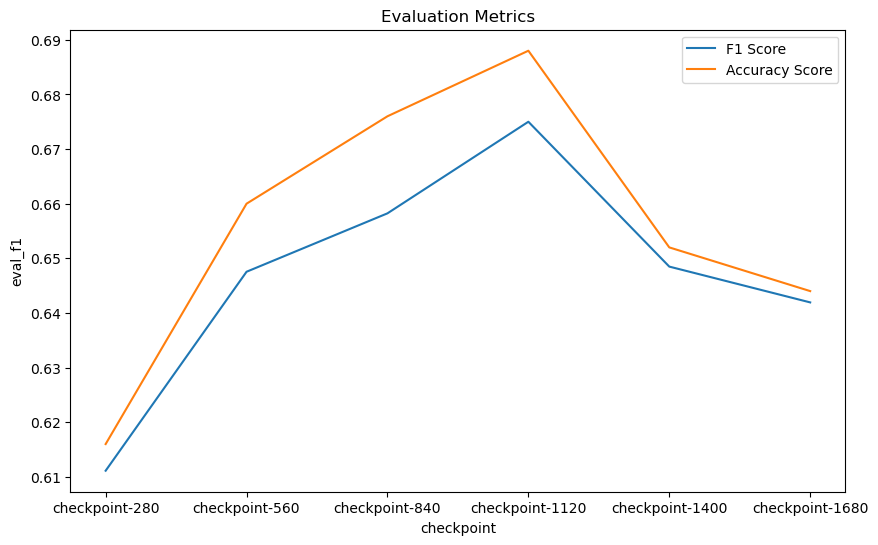

In [22]:
evalCheckpoints(
    ckpt_path="training_dir_rte_BERT",
    checkpoints=[
        "checkpoint-280",
        "checkpoint-560",
        "checkpoint-840",
        "checkpoint-1120",
        "checkpoint-1400",
        "checkpoint-1680",
    ],
    tokenizer=tokenizer_BERT,
    tokenized_datasets=tokenized_datasets_BERT,
)


In [23]:
savedModel_BERT = pipeline('text-classification', model="training_dir_rte_BERT/checkpoint-1120", device=0)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [24]:
preds = savedModel_BERT(raw_dataset['test']['sentence1'], raw_dataset['test']['sentence2'])

preds[:10]

Ignoring args : (['The ban on ivory trade has been effective in protecting the elephant from extinction.', 'Pamuk won a Nobel Prize.', 'Nokia produces mobile chips.', 'Tom Malinowski is director for Human Rights Watch.', 'Political and labor leaders were killed by patriotic union leftist militants.', 'Barak Obama planned US$3.6 trillion in spending.', 'Parmalat costs 14.3 billion euros.', 'The Rolling Stones have begun their latest world tour with a concert in Boston.', 'EuroDisney is located in the charming city of Magny-Le-Hongre.', 'The WSF takes place in Brazil.', 'The banking firm Barings collapsed due to speculations made by Nick Leeson.', 'EU leaders take part in an EU-Japan summit.', 'John Traynor is an executive of Microsoft.', 'Shapiro teaches at NY University.', 'Nike said orders for footwear and apparel for delivery totaled $4.9 billion, including a 12 percent increase in U.S. orders.', 'Ms Robbins is a co-owner of Armstrong Environmental Inc.', 'Air Force is an organisatio

[{'label': 'LABEL_0', 'score': 0.9293341636657715},
 {'label': 'LABEL_0', 'score': 0.953589677810669},
 {'label': 'LABEL_1', 'score': 0.9991462230682373},
 {'label': 'LABEL_1', 'score': 0.9962266683578491},
 {'label': 'LABEL_0', 'score': 0.9636102914810181},
 {'label': 'LABEL_1', 'score': 0.9977695941925049},
 {'label': 'LABEL_0', 'score': 0.9960336089134216},
 {'label': 'LABEL_1', 'score': 0.6843857765197754},
 {'label': 'LABEL_0', 'score': 0.7973372936248779},
 {'label': 'LABEL_0', 'score': 0.9373760223388672}]

In [25]:
preds_labels = [int(d['label'].split('_')[1]) for d in preds]
preds_labels[:10]

[0, 0, 1, 1, 0, 1, 0, 1, 0, 0]

Acc.: 0.564
F1.: 0.555283557731538


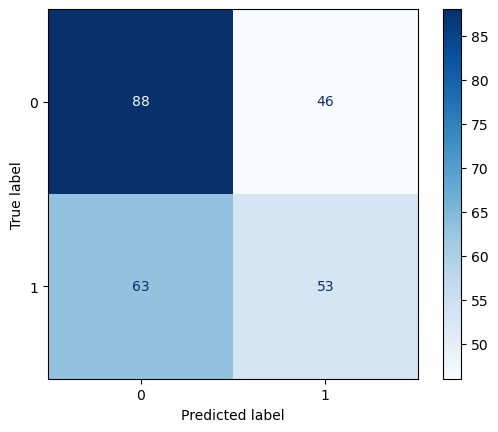

In [26]:
print(f"Acc.: {accuracy_score(y_true=raw_dataset['test']['label'], y_pred=preds_labels)}")
print(f"F1.: {f1_score(y_true=raw_dataset['test']['label'], y_pred=preds_labels, average='macro')}")

cm = confusion_matrix(y_true=raw_dataset['test']['label'], y_pred=preds_labels)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')

In [27]:
# We need to free memory, since it uses gigabytes of memory
!rm -rf ./training_dir_rte_BERT

# del python variables, specially those that are getting lots of GPU memory
del tokenizer_BERT
del tokenize_fn_BERT
del training_args_BERT
del trainer_BERT
del savedModel_BERT
del model_BERT
del preds

## 2.2. Let's do the task for DistilBERT

In [15]:
tokenize_fn_DistilBERT = get_tokenize_fn(tokenizer_DistilBERT)

tokenized_datasets_DiltilBERT = raw_dataset.map(tokenize_fn_DistilBERT, batched=True)
tokenized_datasets_DiltilBERT

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 2240
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 277
    })
})

In [16]:
model_DistilBERT = AutoModelForSequenceClassification.from_pretrained(checkpoint_DistilBERT, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
training_args_DistilBERT = TrainingArguments(
    "training_dir_rte_DistilBERT",
    evaluation_strategy = "epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
)

In [18]:
trainer_DistilBERT = Trainer(
    model_DistilBERT,
    training_args_DistilBERT,
    train_dataset=tokenized_datasets_DiltilBERT['train'],
    eval_dataset=tokenized_datasets_DiltilBERT['validation'],
    tokenizer=tokenizer_DistilBERT,
    compute_metrics=compute_metrics,
)

In [19]:
# pytorch clear GPU memory
torch.cuda.empty_cache()

In [20]:

trainer_DistilBERT.train()

/home/bruno/anaconda3/envs/gpt/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1400 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.7200224995613098, 'eval_accuracy': 0.47653429602888087, 'eval_runtime': 0.9096, 'eval_samples_per_second': 304.523, 'eval_steps_per_second': 19.789, 'epoch': 1.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.69959956407547, 'eval_accuracy': 0.5631768953068592, 'eval_runtime': 1.0822, 'eval_samples_per_second': 255.958, 'eval_steps_per_second': 16.633, 'epoch': 2.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.8672748804092407, 'eval_accuracy': 0.5776173285198556, 'eval_runtime': 1.1749, 'eval_samples_per_second': 235.758, 'eval_steps_per_second': 15.32, 'epoch': 3.0}
{'loss': 0.5246, 'learning_rate': 3.2142857142857144e-05, 'epoch': 3.57}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.3077465295791626, 'eval_accuracy': 0.628158844765343, 'eval_runtime': 1.1561, 'eval_samples_per_second': 239.599, 'eval_steps_per_second': 15.57, 'epoch': 4.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9117366075515747, 'eval_accuracy': 0.592057761732852, 'eval_runtime': 1.1498, 'eval_samples_per_second': 240.922, 'eval_steps_per_second': 15.656, 'epoch': 5.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 2.0734682083129883, 'eval_accuracy': 0.6173285198555957, 'eval_runtime': 1.1262, 'eval_samples_per_second': 245.952, 'eval_steps_per_second': 15.982, 'epoch': 6.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 2.3619308471679688, 'eval_accuracy': 0.6101083032490975, 'eval_runtime': 1.2003, 'eval_samples_per_second': 230.775, 'eval_steps_per_second': 14.996, 'epoch': 7.0}
{'loss': 0.0803, 'learning_rate': 1.4285714285714285e-05, 'epoch': 7.14}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 2.4730875492095947, 'eval_accuracy': 0.6209386281588448, 'eval_runtime': 1.1833, 'eval_samples_per_second': 234.083, 'eval_steps_per_second': 15.211, 'epoch': 8.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 2.563122034072876, 'eval_accuracy': 0.6173285198555957, 'eval_runtime': 1.1454, 'eval_samples_per_second': 241.841, 'eval_steps_per_second': 15.715, 'epoch': 9.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 2.6462562084198, 'eval_accuracy': 0.6028880866425993, 'eval_runtime': 1.1803, 'eval_samples_per_second': 234.683, 'eval_steps_per_second': 15.25, 'epoch': 10.0}
{'train_runtime': 299.1016, 'train_samples_per_second': 74.891, 'train_steps_per_second': 4.681, 'train_loss': 0.2191916230746678, 'epoch': 10.0}


TrainOutput(global_step=1400, training_loss=0.2191916230746678, metrics={'train_runtime': 299.1016, 'train_samples_per_second': 74.891, 'train_steps_per_second': 4.681, 'train_loss': 0.2191916230746678, 'epoch': 10.0})

In [21]:
!ls training_dir_rte_DistilBERT

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
checkpoint-1120  checkpoint-1400  checkpoint-560  checkpoint-980
checkpoint-1260  checkpoint-280   checkpoint-700
checkpoint-140	 checkpoint-420   checkpoint-840


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

        checkpoint eval_accuracy   eval_f1 eval_loss
0   checkpoint-140         0.464   0.31694  0.723102
1   checkpoint-280         0.564  0.550708   0.70406
2   checkpoint-420         0.564  0.561467  0.842768
3   checkpoint-560         0.636  0.612957  1.235893
4   checkpoint-700         0.624  0.619889  1.704331
5   checkpoint-840          0.64  0.628492  1.892052
6   checkpoint-980          0.64   0.63719  2.165268
7  checkpoint-1120          0.62  0.619848  2.587144
8  checkpoint-1260         0.644  0.637687  2.348965
9  checkpoint-1400         0.608  0.606388  2.500496


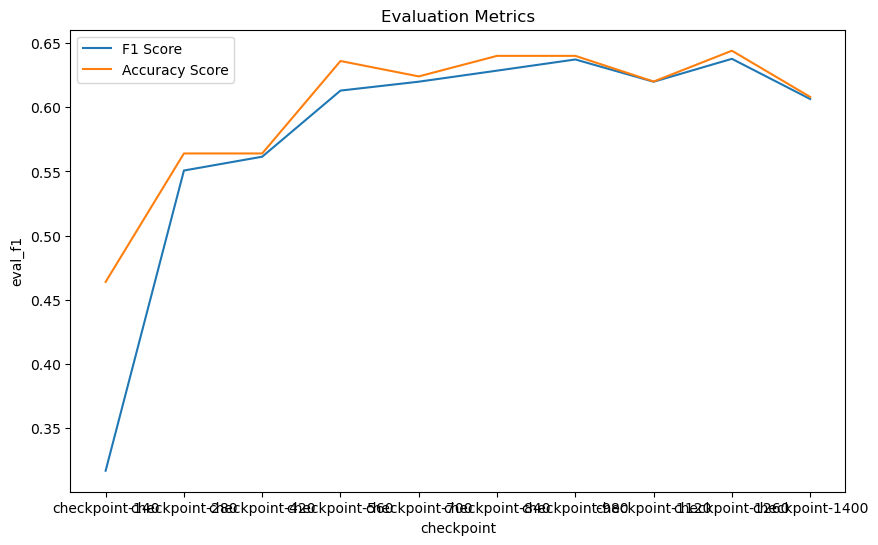

In [27]:
evalCheckpoints(
    ckpt_path="training_dir_rte_DistilBERT",
    checkpoints=[
        "checkpoint-140",
        "checkpoint-280",
        "checkpoint-420",
        "checkpoint-560",
        "checkpoint-700",
        "checkpoint-840",
        "checkpoint-980",
        "checkpoint-1120",
        "checkpoint-1260",
        "checkpoint-1400",
    ],
    tokenizer=tokenizer_DistilBERT,
    tokenized_datasets=tokenized_datasets_DiltilBERT,
)


In [28]:
savedModel_DistilBERT = pipeline('text-classification', model="training_dir_rte_DistilBERT/checkpoint-1260", device=0)

In [29]:
preds = savedModel_DistilBERT(raw_dataset['test']['sentence1'], raw_dataset['test']['sentence2'])

preds[:10]

Ignoring args : (['The ban on ivory trade has been effective in protecting the elephant from extinction.', 'Pamuk won a Nobel Prize.', 'Nokia produces mobile chips.', 'Tom Malinowski is director for Human Rights Watch.', 'Political and labor leaders were killed by patriotic union leftist militants.', 'Barak Obama planned US$3.6 trillion in spending.', 'Parmalat costs 14.3 billion euros.', 'The Rolling Stones have begun their latest world tour with a concert in Boston.', 'EuroDisney is located in the charming city of Magny-Le-Hongre.', 'The WSF takes place in Brazil.', 'The banking firm Barings collapsed due to speculations made by Nick Leeson.', 'EU leaders take part in an EU-Japan summit.', 'John Traynor is an executive of Microsoft.', 'Shapiro teaches at NY University.', 'Nike said orders for footwear and apparel for delivery totaled $4.9 billion, including a 12 percent increase in U.S. orders.', 'Ms Robbins is a co-owner of Armstrong Environmental Inc.', 'Air Force is an organisatio

[{'label': 'LABEL_1', 'score': 0.9996517896652222},
 {'label': 'LABEL_1', 'score': 0.9991357922554016},
 {'label': 'LABEL_1', 'score': 0.9998127818107605},
 {'label': 'LABEL_1', 'score': 0.9980409741401672},
 {'label': 'LABEL_1', 'score': 0.9998817443847656},
 {'label': 'LABEL_1', 'score': 0.9990063309669495},
 {'label': 'LABEL_1', 'score': 0.9998409748077393},
 {'label': 'LABEL_1', 'score': 0.9997665286064148},
 {'label': 'LABEL_1', 'score': 0.9995230436325073},
 {'label': 'LABEL_0', 'score': 0.9913431406021118}]

In [30]:
preds_labels = [int(d['label'].split('_')[1]) for d in preds]
preds_labels[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

Acc.: 0.528
F1.: 0.4770986954055587


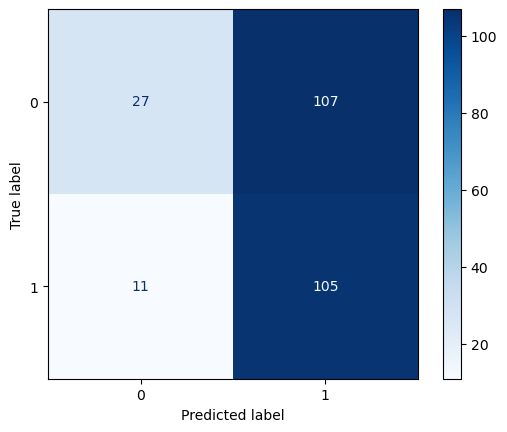

In [31]:
print(f"Acc.: {accuracy_score(y_true=raw_dataset['test']['label'], y_pred=preds_labels)}")
print(f"F1.: {f1_score(y_true=raw_dataset['test']['label'], y_pred=preds_labels, average='macro')}")

cm = confusion_matrix(y_true=raw_dataset['test']['label'], y_pred=preds_labels)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')

In [ ]:
# We need to free memory, since it uses gigabytes of memory
!rm -rf ./training_dir_rte_DistilBERT

# del python variables, specially those that are getting lots of GPU memory
del tokenizer_DistilBERT
del tokenize_fn_DistilBERT
del training_args_DistilBERT
del trainer_DistilBERT
del savedModel_DistilBERT
del model_DistilBERT
del preds